In [1]:
#To mount google drive to colab
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
path_to_folder = "ENPM673/Project_1"
%cd /content/drive/My\ Drive/{path_to_folder}

Mounted at /content/drive/
/content/drive/My Drive/ENPM673/Project_1


In [2]:
#importing open CV, NumPy and matplot libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt



Open video file

In [3]:
vid = cv2.VideoCapture('Ball_travel_2.mp4')

In [4]:
frames = []
#Loop that continues as long as video file is open
while vid.isOpened():
    ret, frame = vid.read()
    if not ret:
        break
    frames.append(frame)
# Release the video capture object
vid.release()
#To print the total number of frames extracted
print(f"Total Frames Extracted: {len(frames)}")

Total Frames Extracted: 24


In [5]:
#function to detect red objects using color thresholding
def detect_red_object(frame):
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)  # Convert to HSV color space from BGR

    # Define the red color range in HSV
    lower_red1 = np.array([0, 120, 70])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 120, 70])
    upper_red2 = np.array([180, 255, 255])

    # Threshold the image to get only red colors
    mask1 = cv2.inRange(hsv_frame, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv_frame, lower_red2, upper_red2)
    mask = cv2.bitwise_or(mask1, mask2)

    return mask  # Returns a binary mask where the red object is white (255)


In [8]:
#function to compute centroids
def calculate_centroid(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #to check if any contours are available in binary mask
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)  # Get the largest detected object
        M = cv2.moments(largest_contour)  # Compute image moments
        # Check if the area (m00) is not zero to avoid division by zero errors
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            return (cx, cy)  # Return the centroid coordinates
    return None  # Return None if no object is detected

#Initialize empty list to store cenroids
centroids = []
# Loop through each frame, detect red objects and compute their centroids.
for frame in frames:
    mask = detect_red_object(frame)
    centroid = calculate_centroid(mask)
    if centroid:
        centroids.append(centroid)  # Store the centroid in the list
#to print total number of centroids found
print(f"Total Centroids Found: {len(centroids)}")

Total Centroids Found: 24


In [10]:
#Least Squares Method
def least_squares_fit(centroids):
    x = np.array([c[0] for c in centroids])
    y = np.array([c[1] for c in centroids])

    A = np.vstack([x**2, x, np.ones(len(x))]).T  # Form the design matrix
    coefficients = np.linalg.lstsq(A, y, rcond=None)[0]  # Solve for a, b, c coefficients of fitting quadratic function

    return coefficients  # Returns [a, b, c]

In [11]:
#RANSAC Method
def ransac_fit(centroids, iterations=100, threshold=10):
    # Initialize variables to track the best model
    best_inliers = 0
    best_coefficients = None
    # Extract x and y coordinates from the centroids list
    x = np.array([c[0] for c in centroids])
    y = np.array([c[1] for c in centroids])
    # Run the RANSAC algorithm for a given number of iterations
    for _ in range(iterations):
        # Randomly select 3 points (indices) from the centroids list
        sample_indices = np.random.choice(len(centroids), 3, replace=False)
        #extracting coordinates
        x_sample = x[sample_indices]
        y_sample = y[sample_indices]
        #form the design matrix and extract coefiiecients of quadratic equation
        A_sample = np.vstack([x_sample**2, x_sample, np.ones(len(x_sample))]).T
        coefficients = np.linalg.lstsq(A_sample, y_sample, rcond=None)[0]

        # Compute predictions for all data points using the fitted model
        A = np.vstack([x**2, x, np.ones(len(x))]).T
        y_pred = np.dot(A, coefficients)
        residuals = np.abs(y - y_pred)
        inliers = np.sum(residuals < threshold)

        # If this model has more inliers than the previous best, update the best model
        if inliers > best_inliers:
            best_inliers = inliers
            best_coefficients = coefficients

    return best_coefficients  #Return the best-fit quadratic coefficients found

In [12]:
#curve fitting
ls_coefficients = least_squares_fit(centroids)
ransac_coefficients = ransac_fit(centroids)

In [13]:
#predicting the y_value at x=1000
x_value = 1000
y_ls = ls_coefficients[0] * x_value**2 + ls_coefficients[1] * x_value + ls_coefficients[2]
y_ransac = ransac_coefficients[0] * x_value**2 + ransac_coefficients[1] * x_value + ransac_coefficients[2]

print(f"y (Least Squares) at x=1000: {y_ls}")
print(f"y (RANSAC) at x=1000: {y_ransac}")

y (Least Squares) at x=1000: 1266.6428762813703
y (RANSAC) at x=1000: 1299.371904101787


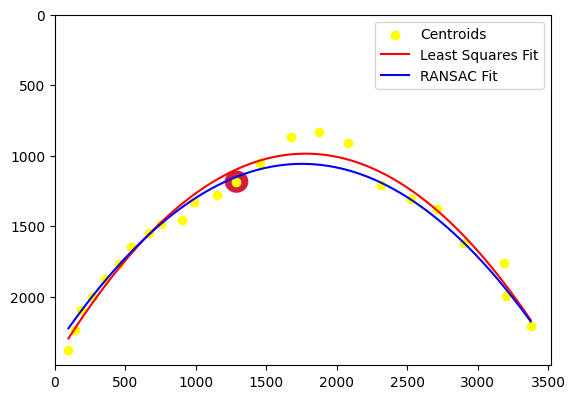

In [14]:
#Visualization of results
def plot_results(frame, centroids, ls_coefficients, ransac_coefficients):
    x = np.array([c[0] for c in centroids])
    y = np.array([c[1] for c in centroids])

    # Generate parabola points
    x_parabola = np.linspace(min(x), max(x), 500)
    y_ls_parabola = ls_coefficients[0] * x_parabola**2 + ls_coefficients[1] * x_parabola + ls_coefficients[2]
    y_ransac_parabola = ransac_coefficients[0] * x_parabola**2 + ransac_coefficients[1] * x_parabola + ransac_coefficients[2]

    # Plot the original frame
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.scatter(x, y, color="yellow", label="Centroids")
    plt.plot(x_parabola, y_ls_parabola, color="red", label="Least Squares Fit")
    plt.plot(x_parabola, y_ransac_parabola, color="blue", label="RANSAC Fit")
    plt.legend()
    plt.show()

# Choose a frame in the middle to plot the results
plot_results(frames[len(frames)//2], centroids, ls_coefficients, ransac_coefficients)